In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import Pool
import time
import dill
from PIL import Image
from collections import defaultdict
import pyamg


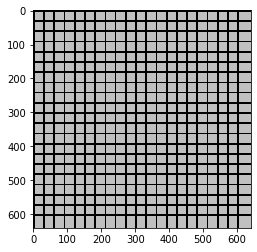

In [2]:
def draw_line(img, color, l, r, hor):
    if hor:
        img[l:r,:,color] = 0
    else:
        img[:,l:r,color] = 0

size = 640
O = np.ones((size, size))
img = cv2.merge([O, O, O]).astype("uint8")
img[img == 1] = 192
n = 30
for i in range(size // n):  
    l = 0 + n * i
    r = 5 + n * i
    for color in range(3):
        draw_line(img, color, l, r, True)
        draw_line(img, color, l, r, False)
        

plt.imshow(img)

In [3]:
def gen_circle(img , center, r):
    color = (255, 255, 255) 
    thickness = -1
    return cv2.circle(img, center, r, color, thickness) 
r = 80
centers = [(150,150), (450, 150) , (450, 450), (150, 450)]
circles = []
for center in centers:
    circles.append(gen_circle(np.copy(img) , center, r))

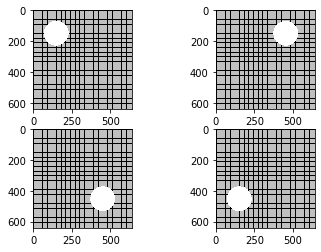

In [4]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(circles[0])
axarr[0,1].imshow(circles[1])
axarr[1,0].imshow(circles[2])
axarr[1,1].imshow(circles[3])

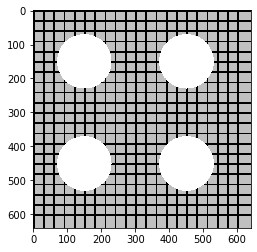

In [37]:
I_colors = defaultdict(list)
for I_k in circles:
    I = cv2.split(I_k)
    for color, value in enumerate(I):
        I_colors[color].append(value)

max_vals = []
for color in range(3):
    max_v = I_colors[color][0]
    for value in I_colors[color][1:]:
        max_v = np.maximum(max_v, value)
    max_vals.append(max_v)

I_max = cv2.merge(max_vals)
plt.imshow(I_max)

mb sobel

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


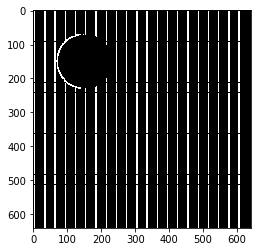

In [53]:
sobelx = cv2.Sobel(circles[0],cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(circles[0],cv2.CV_64F,0,1,ksize=5)
plt.imshow(sobelx)

In [71]:
G_x = []
G_y = []
# G = []
for circle in circles:
    g_x, g_y, g_z = np.gradient(circle)
#     sobelx = cv2.Sobel(circle,cv2.CV_64F,1,0,ksize=5)
#     sobely = cv2.Sobel(circle,cv2.CV_64F,0,1,ksize=5)
#     G_x.append(sobelx)
#     G_y.append(sobely)
    G_x.append(g_x)
    G_y.append(g_y)
#     G.append(g_x + g_y)
G_median_x = np.median(G_x, axis=0)
G_median_y = np.median(G_y, axis=0)
# G_median = np.median(G, axis=0)

In [8]:
G_median_colors = cv2.split(G_median)

div_G = []
for median_color in G_median_colors:
    g_x, g_y = np.gradient(median_color)
    div_G.append(g_x + g_y)

In [72]:
div_G = []
G_median_x_colors = cv2.split(G_median_x)
G_median_y_colors = cv2.split(G_median_y)
for x, y in zip(G_median_x_colors, G_median_y_colors):
    x_x, x_y = np.gradient(x)
    y_x, y_y = np.gradient(y)
    div_G.append(x_x + y_y)

In [73]:
shape = (size, size)

_I = []

for div_color in div_G:
    A = pyamg.gallery.poisson(shape, format='csr')  # 2D Poisson problem on 500x500 grid
    ml = pyamg.ruge_stuben_solver(A)                    # construct the multigrid hierarchy
    print(ml)                                           # print hierarchy information
    b = div_color.ravel()
    x = ml.solve(b, tol=1e-10)
    _I.append(np.reshape(x, (-1, size)))
    print("residual: ", np.linalg.norm(b-A*x)) 
    print("=" * 20)

D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.199
Grid Complexity:      1.666
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0       409600      2045440 [45.47%]
    1       204800      1838082 [40.86%]
    2        51202       459960 [10.22%]
    3        12661       114727 [ 2.55%]
    4         3165        29699 [ 0.66%]
    5          790         7916 [ 0.18%]
    6          199         2069 [ 0.05%]
    7           52          612 [ 0.01%]
    8           13          111 [ 0.00%]
    9            3            9 [ 0.00%]

residual:  1.4207260900518638e-06


D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.199
Grid Complexity:      1.666
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0       409600      2045440 [45.47%]
    1       204800      1838082 [40.86%]
    2        51202       459960 [10.22%]
    3        12661       114727 [ 2.55%]
    4         3165        29699 [ 0.66%]
    5          790         7916 [ 0.18%]
    6          199         2069 [ 0.05%]
    7           52          612 [ 0.01%]
    8           13          111 [ 0.00%]
    9            3            9 [ 0.00%]

residual:  1.4207260900518638e-06


D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
D:\anaconda\lib\site-packages\pyamg\gallery\stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


multilevel_solver
Number of Levels:     10
Operator Complexity:  2.199
Grid Complexity:      1.666
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0       409600      2045440 [45.47%]
    1       204800      1838082 [40.86%]
    2        51202       459960 [10.22%]
    3        12661       114727 [ 2.55%]
    4         3165        29699 [ 0.66%]
    5          790         7916 [ 0.18%]
    6          199         2069 [ 0.05%]
    7           52          612 [ 0.01%]
    8           13          111 [ 0.00%]
    9            3            9 [ 0.00%]

residual:  1.4207260900518638e-06


In [78]:
_I5 = cv2.merge(_I)
_I5[_I5 < 0] = 0
_I5 = _I5.astype('uint8')
np.unique(_I5)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166], dtype=uint8)

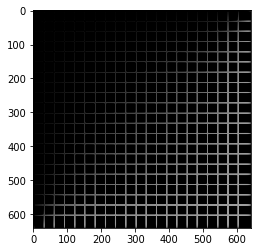

In [80]:
plt.imshow(_I5)

In [79]:
np.unique(I_max), np.unique(_I5)

(array([  0, 192, 255], dtype=uint8),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166], dtype=uint8))

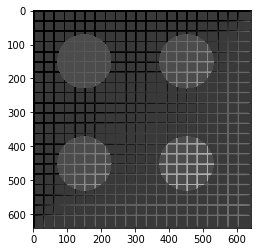

In [82]:
alpha = 0.7
R = alpha * _I5 + (1 - alpha) * I_max
R[R > 255] = 255
R = R.astype('uint8')
plt.imshow(R)